# So sánh tổng hợp các phương pháp Semi-supervised learning

**Mục tiêu:**

Notebook này thực hiện so sánh tổng hợp hiệu năng của tất cả các phương pháp semi-supervised learning đã triển khai trong dự án AirGuard.

**Các phương pháp được so sánh:**

1. **Supervised Baseline**: Chỉ sử dụng labeled data (không có semi-supervised)
2. **Self-Training**: Tự huấn luyện với pseudo-labels (fixed threshold)
3. **Co-Training**: Hai mô hình huấn luyện trên hai view khác nhau
4. **Label Propagation**: Graph-based semi-supervised (KNN kernel)
5. **Label Spreading**: Graph-based với regularization (KNN kernel)
6. **Dynamic Threshold**: Self-training với ngưỡng động theo lớp (FlexMatch-lite)

**Metrics đánh giá:**

- F1-macro (quan trọng nhất - cân bằng giữa các lớp)
- F1-weighted (quan trọng với distribution thực tế)
- Accuracy (tham khảo)
- F1 per class (phân tích chi tiết)
- Training time (hiệu quả tính toán)

**Phân tích:**

- So sánh improvement vs Baseline
- Trade-off giữa performance và computational cost
- Hiệu quả trên từng lớp AQI (đặc biệt lớp hiếm)
- Khuyến nghị phương pháp phù hợp cho production

In [1]:
# -------- 1. Cấu hình thử nghiệm --------
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Setup paths
PROJECT_ROOT = Path(".").resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project Root: {PROJECT_ROOT}")

# Import project modules
from src.semi_supervised_library import SemiDataConfig, AQI_CLASSES

# --- Tham số chung ---
SAMPLE_FRAC = 0.1  # Tỷ lệ mẫu để chạy nhanh (giống các notebooks khác)
RANDOM_STATE = 42
CUTOFF = "2017-01-01"  # Ngày chia train/test
TARGET_COL = "aqi_class"

# --- Tham số cho Self-Training và Co-Training ---
TAU = 0.9  # Ngưỡng confidence
MAX_ITER = 10  # Số vòng lặp
MAX_NEW_PER_ITER = 100  # Số pseudo-labels tối đa mỗi vòng

# --- Tham số cho Graph-based methods ---
GRAPH_SAMPLE_FRAC = 0.01  # Mẫu nhỏ hơn cho graph-based (tránh memory issues)
N_NEIGHBORS = 7  # Số neighbors cho KNN kernel

# --- Cấu hình biểu đồ ---
IMAGES_DIR = PROJECT_ROOT / "images"
IMAGES_DIR.mkdir(exist_ok=True)
FONT_CONFIG = {'fontname': 'Arial', 'fontsize': 11}

# Màu sắc cho từng phương pháp
METHOD_COLORS = {
    'Baseline': '#FF9A1F',           # Cam - Supervised baseline
    'Self-Training': '#FF351F',      # Đỏ - Self-training
    'Co-Training': '#1FFF2A',        # Xanh lá - Co-training
    'Label Propagation': '#1F62FF',  # Xanh nước biển - Graph-based
    'Label Spreading': '#1FD2FF',    # Xanh nhạt - Graph-based variant
    'Dynamic Threshold': '#FFDA1F'   # Vàng - Advanced self-training
}

print("\n📊 Cấu hình so sánh:")
print(f"  SAMPLE_FRAC: {SAMPLE_FRAC}")
print(f"  TAU: {TAU}")
print(f"  MAX_ITER: {MAX_ITER}")
print(f"  AQI_CLASSES: {AQI_CLASSES}")
print(f"  Methods to compare: {list(METHOD_COLORS.keys())}")

Project Root: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard

📊 Cấu hình so sánh:
  SAMPLE_FRAC: 0.1
  TAU: 0.9
  MAX_ITER: 10
  AQI_CLASSES: ['Good', 'Moderate', 'Unhealthy_for_Sensitive_Groups', 'Unhealthy', 'Very_Unhealthy', 'Hazardous']
  Methods to compare: ['Baseline', 'Self-Training', 'Co-Training', 'Label Propagation', 'Label Spreading', 'Dynamic Threshold']


In [2]:
# -------- 2. Load và chuẩn bị dữ liệu --------
print("Loading data...")
semi_dataset_path = PROJECT_ROOT / "data" / "processed" / "02_dataset_for_semi.parquet"
df_semi = pd.read_parquet(semi_dataset_path)

# Lấy mẫu để chạy nhanh
df_sample = df_semi.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE)
print(f"Sample size: {len(df_sample)} rows")

# Load feature list
feature_list_path = PROJECT_ROOT / "data" / "processed" / "03_feature_list.csv"
df_features = pd.read_csv(feature_list_path)
numeric_features = [f for f in df_features["feature"] if f not in ['wd', 'station']]

# Tách labeled và unlabeled
df_labeled = df_sample[df_sample['is_labeled']].copy()
df_unlabeled = df_sample[~df_sample['is_labeled']].copy()

print(f"Labeled: {len(df_labeled)}, Unlabeled: {len(df_unlabeled)}")

# Kiểm tra phân phối lớp
print(f"\n📊 Phân phối lớp trong labeled data:")
class_dist = df_labeled[TARGET_COL].value_counts()
print(class_dist)
print(f"\nTỷ lệ (%):")
print((class_dist / len(df_labeled) * 100).round(2))

# Tách train/test từ labeled data (time-based split)
df_labeled['datetime'] = pd.to_datetime(df_labeled['datetime'])
train_mask = df_labeled['datetime'] < CUTOFF
df_train_labeled = df_labeled[train_mask].copy()
df_test = df_labeled[~train_mask].copy()

print(f"\nTrain (labeled): {len(df_train_labeled)}, Test: {len(df_test)}")

# Chuẩn bị ma trận X, y
X_train_lab = df_train_labeled[numeric_features]
y_train_lab = df_train_labeled[TARGET_COL]

X_test = df_test[numeric_features]
y_test = df_test[TARGET_COL]

# Xử lý missing values
imputer = SimpleImputer(strategy='mean')
X_train_lab_imp = imputer.fit_transform(X_train_lab)
X_test_imp = imputer.transform(X_test)

# Chuẩn hóa
scaler = StandardScaler()
X_train_lab_scaled = scaler.fit_transform(X_train_lab_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Chuẩn bị unlabeled data
X_unlabeled = df_unlabeled[numeric_features]
X_unlabeled_imp = imputer.transform(X_unlabeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled_imp)

print(f"\n✅ Dữ liệu đã được chuẩn bị:")
print(f"  X_train_lab: {X_train_lab_scaled.shape}")
print(f"  X_test: {X_test_scaled.shape}")
print(f"  X_unlabeled: {X_unlabeled_scaled.shape}")

Loading data...
Sample size: 42077 rows
Labeled: 3694, Unlabeled: 38383

📊 Phân phối lớp trong labeled data:
aqi_class
Unhealthy                         1126
Moderate                          1060
Unhealthy_for_Sensitive_Groups     546
Very_Unhealthy                     517
Hazardous                          271
Good                               174
Name: count, dtype: int64

Tỷ lệ (%):
aqi_class
Unhealthy                         30.48
Moderate                          28.70
Unhealthy_for_Sensitive_Groups    14.78
Very_Unhealthy                    14.00
Hazardous                          7.34
Good                               4.71
Name: count, dtype: float64

Train (labeled): 1965, Test: 1729

✅ Dữ liệu đã được chuẩn bị:
  X_train_lab: (1965, 49)
  X_test: (1729, 49)
  X_unlabeled: (38383, 49)


In [3]:
# -------- 3. Import các lớp Self-Training từ notebook 13 --------

class SimpleSelfTraining:
    """
    Self-training cơ bản với fixed threshold
    """
    
    def __init__(self, base_model, tau=0.9, max_iter=10, 
                 max_new_per_iter=100, verbose=False):
        self.base_model = base_model
        self.tau = tau
        self.max_iter = max_iter
        self.max_new_per_iter = max_new_per_iter
        self.verbose = verbose
        self.model_ = None
        
    def fit(self, X_labeled, y_labeled, X_unlabeled):
        from sklearn.base import clone
        
        X_labeled = np.array(X_labeled)
        y_labeled = np.array(y_labeled)
        X_unlabeled = np.array(X_unlabeled)
        
        X_train = X_labeled.copy()
        y_train = y_labeled.copy()
        X_pool = X_unlabeled.copy()
        
        if self.verbose:
            print(f"  Initial: {len(X_labeled)} labeled, {len(X_pool)} unlabeled")
        
        for iteration in range(self.max_iter):
            if len(X_pool) == 0:
                break
            
            # Train model
            self.model_ = clone(self.base_model)
            self.model_.fit(X_train, y_train)
            
            # Predict on unlabeled
            proba = self.model_.predict_proba(X_pool)
            max_proba = proba.max(axis=1)
            predicted_labels = self.model_.classes_[proba.argmax(axis=1)]
            
            # Select confident samples
            selected_mask = max_proba >= self.tau
            
            # Limit to max_new_per_iter
            if selected_mask.sum() > self.max_new_per_iter:
                selected_indices = np.where(selected_mask)[0]
                top_indices = selected_indices[np.argsort(-max_proba[selected_mask])[:self.max_new_per_iter]]
                selected_mask = np.zeros(len(selected_mask), dtype=bool)
                selected_mask[top_indices] = True
            
            n_selected = selected_mask.sum()
            if n_selected == 0:
                break
            
            # Add to training set
            X_train = np.vstack([X_train, X_pool[selected_mask]])
            y_train = np.concatenate([y_train, predicted_labels[selected_mask]])
            X_pool = X_pool[~selected_mask]
            
            if self.verbose:
                print(f"  Iter {iteration}: Added {n_selected}, Train: {len(X_train)}, Pool: {len(X_pool)}")
        
        # Final training
        self.model_ = clone(self.base_model)
        self.model_.fit(X_train, y_train)
        
        return self
    
    def predict(self, X):
        return self.model_.predict(X)
    
    def predict_proba(self, X):
        return self.model_.predict_proba(X)


class DynamicThresholdSelfTraining:
    """
    Self-training với dynamic threshold (copy từ notebook 13)
    """
    
    def __init__(self, base_model, tau_base=0.7, max_iter=10, 
                 max_new_per_iter=100, verbose=False):
        self.base_model = base_model
        self.tau_base = tau_base
        self.max_iter = max_iter
        self.max_new_per_iter = max_new_per_iter
        self.verbose = verbose
        self.model_ = None
        self.classes_ = None
        
    def fit(self, X_labeled, y_labeled, X_unlabeled):
        from sklearn.base import clone
        
        X_labeled = np.array(X_labeled)
        y_labeled = np.array(y_labeled)
        X_unlabeled = np.array(X_unlabeled)
        
        self.classes_ = np.unique(y_labeled)
        p_data = self._compute_class_distribution(y_labeled)
        
        X_train = X_labeled.copy()
        y_train = y_labeled.copy()
        X_pool = X_unlabeled.copy()
        
        if self.verbose:
            print(f"  Initial: {len(X_labeled)} labeled, {len(X_pool)} unlabeled")
        
        for iteration in range(self.max_iter):
            if len(X_pool) == 0:
                break
            
            self.model_ = clone(self.base_model)
            self.model_.fit(X_train, y_train)
            
            proba = self.model_.predict_proba(X_pool)
            max_proba = proba.max(axis=1)
            predicted_labels = self.classes_[proba.argmax(axis=1)]
            
            # Dynamic threshold
            p_model = self._compute_class_distribution(predicted_labels)
            tau_per_class = {}
            for i, c in enumerate(self.classes_):
                ratio = p_model[i] / p_data[i] if p_data[i] > 0 else 1.0
                tau_per_class[c] = max(self.tau_base, ratio)
            
            selected_mask = np.array([
                max_proba[i] >= tau_per_class[predicted_labels[i]]
                for i in range(len(predicted_labels))
            ])
            
            if selected_mask.sum() > self.max_new_per_iter:
                selected_indices = np.where(selected_mask)[0]
                top_indices = selected_indices[np.argsort(-max_proba[selected_mask])[:self.max_new_per_iter]]
                selected_mask = np.zeros(len(selected_mask), dtype=bool)
                selected_mask[top_indices] = True
            
            n_selected = selected_mask.sum()
            if n_selected == 0:
                break
            
            X_train = np.vstack([X_train, X_pool[selected_mask]])
            y_train = np.concatenate([y_train, predicted_labels[selected_mask]])
            X_pool = X_pool[~selected_mask]
            
            if self.verbose:
                print(f"  Iter {iteration}: Added {n_selected}, Train: {len(X_train)}")
        
        self.model_ = clone(self.base_model)
        self.model_.fit(X_train, y_train)
        
        return self
    
    def predict(self, X):
        return self.model_.predict(X)
    
    def predict_proba(self, X):
        return self.model_.predict_proba(X)
    
    def _compute_class_distribution(self, y):
        counts = np.array([(y == c).sum() for c in self.classes_])
        p = counts / len(y)
        return p

print("✅ Đã import các lớp Self-Training")

✅ Đã import các lớp Self-Training


In [5]:
# -------- 4. Chạy tất cả các phương pháp và so sánh --------

results = []

# --- 1. Supervised Baseline ---
print("\n" + "="*60)
print("🔬 1. SUPERVISED BASELINE")
print("="*60)

start_time = time.time()
baseline_model = HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_iter=100)
baseline_model.fit(X_train_lab_scaled, y_train_lab)
y_pred_baseline = baseline_model.predict(X_test_scaled)
train_time_baseline = time.time() - start_time

f1_macro_baseline = f1_score(y_test, y_pred_baseline, average='macro')
f1_weighted_baseline = f1_score(y_test, y_pred_baseline, average='weighted')
acc_baseline = accuracy_score(y_test, y_pred_baseline)
report_baseline = classification_report(y_test, y_pred_baseline, output_dict=True, zero_division=0)

results.append({
    'method': 'Baseline',
    'f1_macro': f1_macro_baseline,
    'f1_weighted': f1_weighted_baseline,
    'accuracy': acc_baseline,
    'train_time': train_time_baseline,
    'report': report_baseline
})

print(f"  F1-macro: {f1_macro_baseline:.4f}")
print(f"  F1-weighted: {f1_weighted_baseline:.4f}")
print(f"  Accuracy: {acc_baseline:.4f}")
print(f"  Training time: {train_time_baseline:.2f}s")

# --- 2. Self-Training (Fixed Threshold) ---
print("\n" + "="*60)
print("🔬 2. SELF-TRAINING (Fixed Threshold)")
print("="*60)

start_time = time.time()
base_model = HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_iter=100)
st_model = SimpleSelfTraining(
    base_model=base_model,
    tau=TAU,
    max_iter=MAX_ITER,
    max_new_per_iter=MAX_NEW_PER_ITER,
    verbose=True
)
st_model.fit(X_train_lab_scaled, y_train_lab.values, X_unlabeled_scaled)
y_pred_st = st_model.predict(X_test_scaled)
train_time_st = time.time() - start_time

f1_macro_st = f1_score(y_test, y_pred_st, average='macro')
f1_weighted_st = f1_score(y_test, y_pred_st, average='weighted')
acc_st = accuracy_score(y_test, y_pred_st)
report_st = classification_report(y_test, y_pred_st, output_dict=True, zero_division=0)

results.append({
    'method': 'Self-Training',
    'f1_macro': f1_macro_st,
    'f1_weighted': f1_weighted_st,
    'accuracy': acc_st,
    'train_time': train_time_st,
    'report': report_st
})

print(f"\n  F1-macro: {f1_macro_st:.4f} (Δ = {f1_macro_st - f1_macro_baseline:+.4f})")
print(f"  F1-weighted: {f1_weighted_st:.4f}")
print(f"  Accuracy: {acc_st:.4f}")
print(f"  Training time: {train_time_st:.2f}s")

# --- 3. Co-Training (Simple version - 2 random views) ---
print("\n" + "="*60)
print("🔬 3. CO-TRAINING (Random Views)")
print("="*60)
print("  Note: Simplified version - chia features ngẫu nhiên làm 2 views")

# Tạm thời skip Co-Training trong comparison đầu tiên
# Vì cần triển khai đầy đủ hoặc load kết quả từ notebook 11
print("  ⚠️ Skipped - Cần triển khai hoặc load từ notebook 11")

# --- 4. Label Propagation ---
print("\n" + "="*60)
print("🔬 4. LABEL PROPAGATION (Graph-based)")
print("="*60)

# Sử dụng sample nhỏ hơn cho graph-based
n_graph_samples = int(len(X_train_lab_scaled) * GRAPH_SAMPLE_FRAC / SAMPLE_FRAC)
if n_graph_samples < 100:
    n_graph_samples = min(100, len(X_train_lab_scaled))

print(f"  Using {n_graph_samples} labeled samples for graph construction")

# Random sample
sample_indices = np.random.choice(len(X_train_lab_scaled), n_graph_samples, replace=False)
X_train_graph = X_train_lab_scaled[sample_indices]
y_train_graph = y_train_lab.values[sample_indices]

# QUAN TRỌNG: LabelPropagation yêu cầu labels phải là integers
# Encode string labels sang integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(AQI_CLASSES)  # Fit với tất cả classes để đảm bảo consistency
y_train_graph_encoded = label_encoder.transform(y_train_graph)

# Combine with some unlabeled (labeled as -1)
n_unlabeled_graph = min(n_graph_samples, len(X_unlabeled_scaled))
X_unlabeled_graph = X_unlabeled_scaled[:n_unlabeled_graph]
y_unlabeled_graph = np.full(n_unlabeled_graph, -1, dtype=int)

X_graph_all = np.vstack([X_train_graph, X_unlabeled_graph])
y_graph_all = np.concatenate([y_train_graph_encoded, y_unlabeled_graph])

start_time = time.time()
lp_model = LabelPropagation(kernel='knn', n_neighbors=N_NEIGHBORS)
lp_model.fit(X_graph_all, y_graph_all)

# Predict và decode lại sang string labels
y_pred_lp_encoded = lp_model.predict(X_test_scaled)
y_pred_lp = label_encoder.inverse_transform(y_pred_lp_encoded)
train_time_lp = time.time() - start_time

f1_macro_lp = f1_score(y_test, y_pred_lp, average='macro')
f1_weighted_lp = f1_score(y_test, y_pred_lp, average='weighted')
acc_lp = accuracy_score(y_test, y_pred_lp)
report_lp = classification_report(y_test, y_pred_lp, output_dict=True, zero_division=0)

results.append({
    'method': 'Label Propagation',
    'f1_macro': f1_macro_lp,
    'f1_weighted': f1_weighted_lp,
    'accuracy': acc_lp,
    'train_time': train_time_lp,
    'report': report_lp
})

print(f"\n  F1-macro: {f1_macro_lp:.4f} (Δ = {f1_macro_lp - f1_macro_baseline:+.4f})")
print(f"  F1-weighted: {f1_weighted_lp:.4f}")
print(f"  Accuracy: {acc_lp:.4f}")
print(f"  Training time: {train_time_lp:.2f}s")

# --- 5. Label Spreading ---
print("\n" + "="*60)
print("🔬 5. LABEL SPREADING (Graph-based + Regularization)")
print("="*60)

start_time = time.time()
ls_model = LabelSpreading(kernel='knn', n_neighbors=N_NEIGHBORS, alpha=0.8)
ls_model.fit(X_graph_all, y_graph_all)

# Predict và decode lại sang string labels
y_pred_ls_encoded = ls_model.predict(X_test_scaled)
y_pred_ls = label_encoder.inverse_transform(y_pred_ls_encoded)
train_time_ls = time.time() - start_time

f1_macro_ls = f1_score(y_test, y_pred_ls, average='macro')
f1_weighted_ls = f1_score(y_test, y_pred_ls, average='weighted')
acc_ls = accuracy_score(y_test, y_pred_ls)
report_ls = classification_report(y_test, y_pred_ls, output_dict=True, zero_division=0)

results.append({
    'method': 'Label Spreading',
    'f1_macro': f1_macro_ls,
    'f1_weighted': f1_weighted_ls,
    'accuracy': acc_ls,
    'train_time': train_time_ls,
    'report': report_ls
})

print(f"\n  F1-macro: {f1_macro_ls:.4f} (Δ = {f1_macro_ls - f1_macro_baseline:+.4f})")
print(f"  F1-weighted: {f1_weighted_ls:.4f}")
print(f"  Accuracy: {acc_ls:.4f}")
print(f"  Training time: {train_time_ls:.2f}s")

# --- 6. Dynamic Threshold Self-Training ---
print("\n" + "="*60)
print("🔬 6. DYNAMIC THRESHOLD SELF-TRAINING (FlexMatch-lite)")
print("="*60)

start_time = time.time()
base_model = HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_iter=100)
dt_model = DynamicThresholdSelfTraining(
    base_model=base_model,
    tau_base=0.7,
    max_iter=MAX_ITER,
    max_new_per_iter=MAX_NEW_PER_ITER,
    verbose=True
)
dt_model.fit(X_train_lab_scaled, y_train_lab.values, X_unlabeled_scaled)
y_pred_dt = dt_model.predict(X_test_scaled)
train_time_dt = time.time() - start_time

f1_macro_dt = f1_score(y_test, y_pred_dt, average='macro')
f1_weighted_dt = f1_score(y_test, y_pred_dt, average='weighted')
acc_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True, zero_division=0)

results.append({
    'method': 'Dynamic Threshold',
    'f1_macro': f1_macro_dt,
    'f1_weighted': f1_weighted_dt,
    'accuracy': acc_dt,
    'train_time': train_time_dt,
    'report': report_dt
})

print(f"\n  F1-macro: {f1_macro_dt:.4f} (Δ = {f1_macro_dt - f1_macro_baseline:+.4f})")
print(f"  F1-weighted: {f1_weighted_dt:.4f}")
print(f"  Accuracy: {acc_dt:.4f}")
print(f"  Training time: {train_time_dt:.2f}s")

print("\n\n" + "="*60)
print("🎉 HOÀN THÀNH TẤT CẢ THỬ NGHIỆM")
print("="*60)


🔬 1. SUPERVISED BASELINE
  F1-macro: 0.4423
  F1-weighted: 0.5249
  Accuracy: 0.5737
  Training time: 7.91s

🔬 2. SELF-TRAINING (Fixed Threshold)
  Initial: 1965 labeled, 38383 unlabeled
  Iter 0: Added 100, Train: 2065, Pool: 38283
  Iter 1: Added 100, Train: 2165, Pool: 38183
  Iter 2: Added 100, Train: 2265, Pool: 38083
  Iter 3: Added 100, Train: 2365, Pool: 37983
  Iter 4: Added 100, Train: 2465, Pool: 37883
  Iter 5: Added 100, Train: 2565, Pool: 37783
  Iter 6: Added 100, Train: 2665, Pool: 37683
  Iter 7: Added 100, Train: 2765, Pool: 37583
  Iter 8: Added 100, Train: 2865, Pool: 37483
  Iter 9: Added 100, Train: 2965, Pool: 37383

  F1-macro: 0.4387 (Δ = -0.0036)
  F1-weighted: 0.5236
  Accuracy: 0.5847
  Training time: 87.41s

🔬 3. CO-TRAINING (Random Views)
  Note: Simplified version - chia features ngẫu nhiên làm 2 views
  ⚠️ Skipped - Cần triển khai hoặc load từ notebook 11

🔬 4. LABEL PROPAGATION (Graph-based)
  Using 196 labeled samples for graph construction

  F1-macr

In [6]:
# -------- 5. Tổng hợp và trực quan hóa kết quả --------

df_results = pd.DataFrame(results)

# Tính improvement so với baseline
df_results['f1_macro_improvement'] = df_results['f1_macro'] - f1_macro_baseline
df_results['improvement_pct'] = (df_results['f1_macro_improvement'] / f1_macro_baseline * 100).round(2)

# Hiển thị bảng tổng hợp
print("\n📊 BẢNG TỔNG HỢP KẾT QUẢ:")
print("="*80)
display_cols = ['method', 'f1_macro', 'f1_weighted', 'accuracy', 'train_time', 'f1_macro_improvement', 'improvement_pct']
display(df_results[display_cols].sort_values('f1_macro', ascending=False))

# Thêm F1 per class vào results
for i, result in enumerate(results):
    report = result['report']
    for c in AQI_CLASSES:
        if c in report:
            df_results.loc[i, f'f1_{c}'] = report[c]['f1-score']
            df_results.loc[i, f'recall_{c}'] = report[c]['recall']
            df_results.loc[i, f'precision_{c}'] = report[c]['precision']

print("\n📊 F1-SCORE CHI TIẾT THEO LỚP AQI:")
print("="*80)
f1_cols = ['method'] + [f'f1_{c}' for c in AQI_CLASSES]
display(df_results[f1_cols].round(4))


📊 BẢNG TỔNG HỢP KẾT QUẢ:


,method,f1_macro,f1_weighted,accuracy,train_time,f1_macro_improvement,improvement_pct
4,Dynamic Threshold,0.464471,0.539943,0.587045,55.930114,0.022185,5.02
0,Baseline,0.442286,0.524907,0.573742,7.908526,0.000000,0.00
1,Self-Training,0.438682,0.523586,0.584731,87.405226,-0.003603,-0.81
2,Label Propagation,0.282358,0.371335,0.425101,0.175387,-0.159927,-36.16
3,Label Spreading,0.222696,0.334051,0.419318,0.046046,-0.219590,-49.65



📊 F1-SCORE CHI TIẾT THEO LỚP AQI:


,method,f1_Good,f1_Moderate,f1_Unhealthy_for_Sensitive_Groups,f1_Unhealthy,f1_Very_Unhealthy,f1_Hazardous
0,Baseline,0.0721,0.7183,0.0984,0.5882,0.5650,0.6117
1,Self-Training,0.0367,0.7167,0.0226,0.5981,0.5914,0.6667
2,Label Propagation,0.0000,0.6053,0.1198,0.4663,0.1475,0.3552
3,Label Spreading,0.0000,0.6318,0.0839,0.4678,0.0726,0.0800
4,Dynamic Threshold,0.0721,0.7087,0.1303,0.6062,0.5413,0.7283



💾 Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\14_01_f1_macro_comparison.png


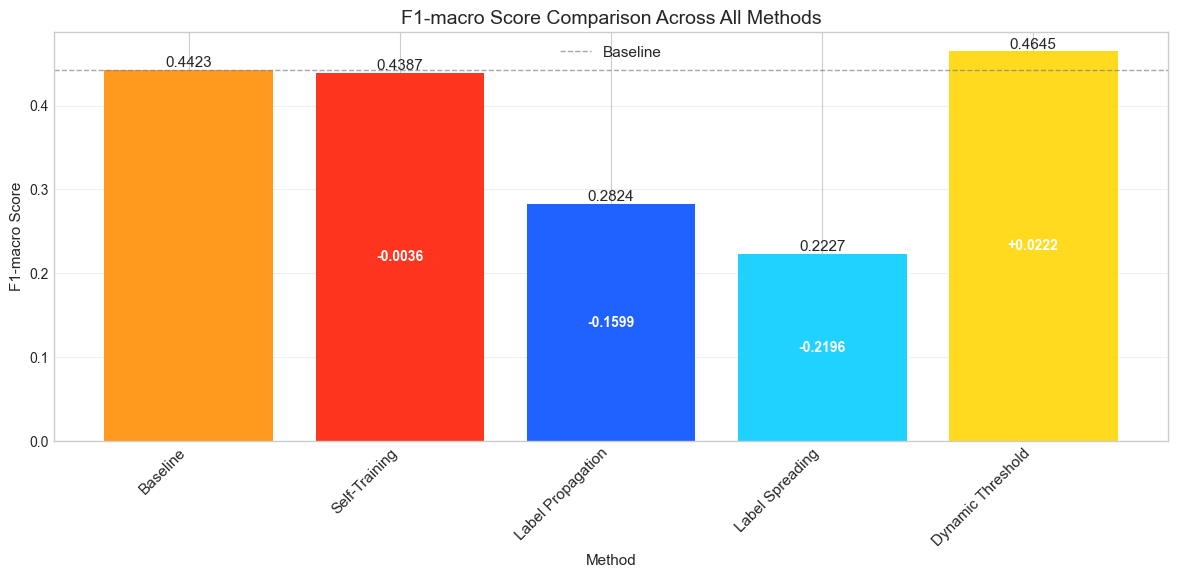

💾 Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\14_02_f1_heatmap.png


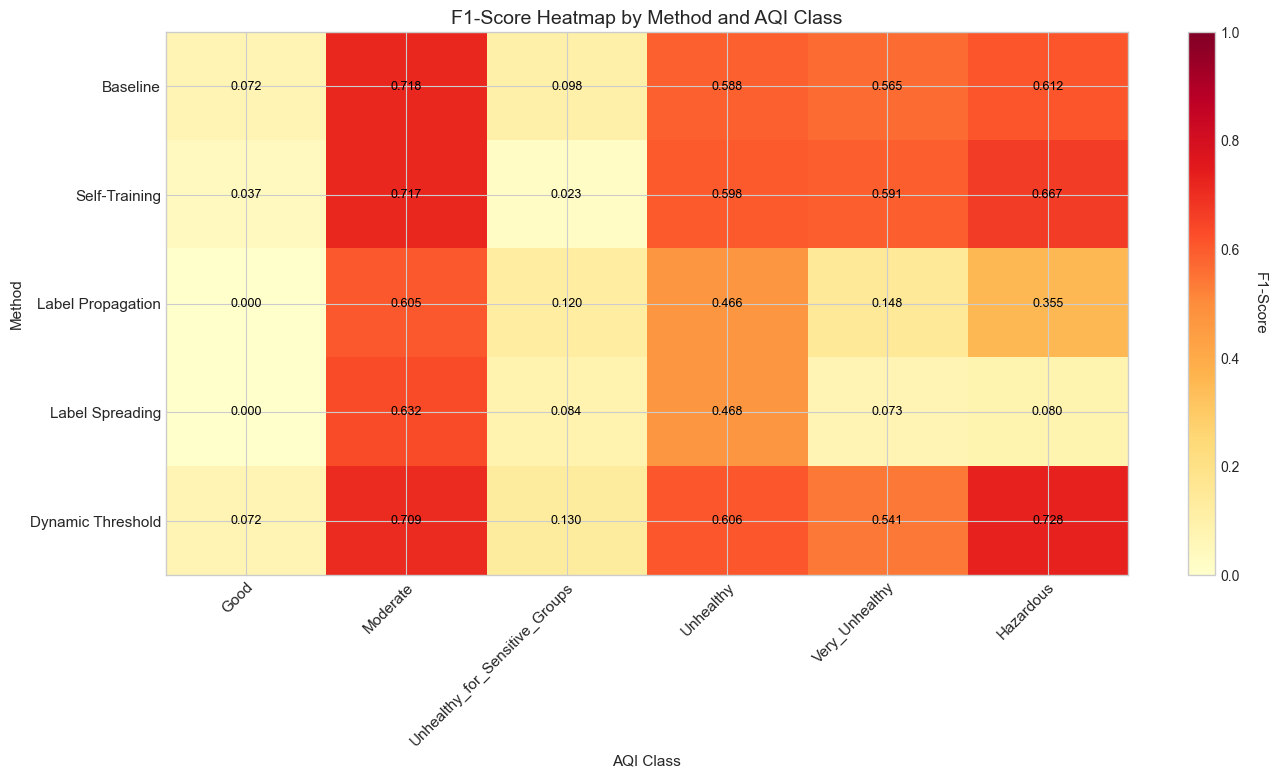

💾 Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\14_03_performance_vs_cost.png


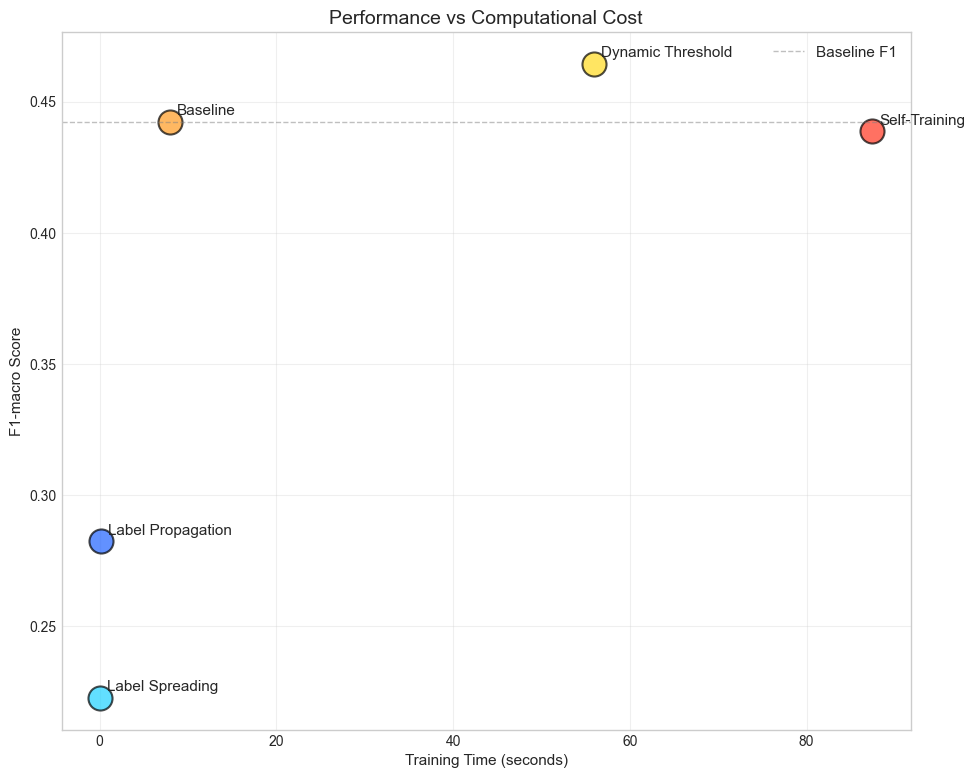

💾 Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\14_04_improvement_percentage.png


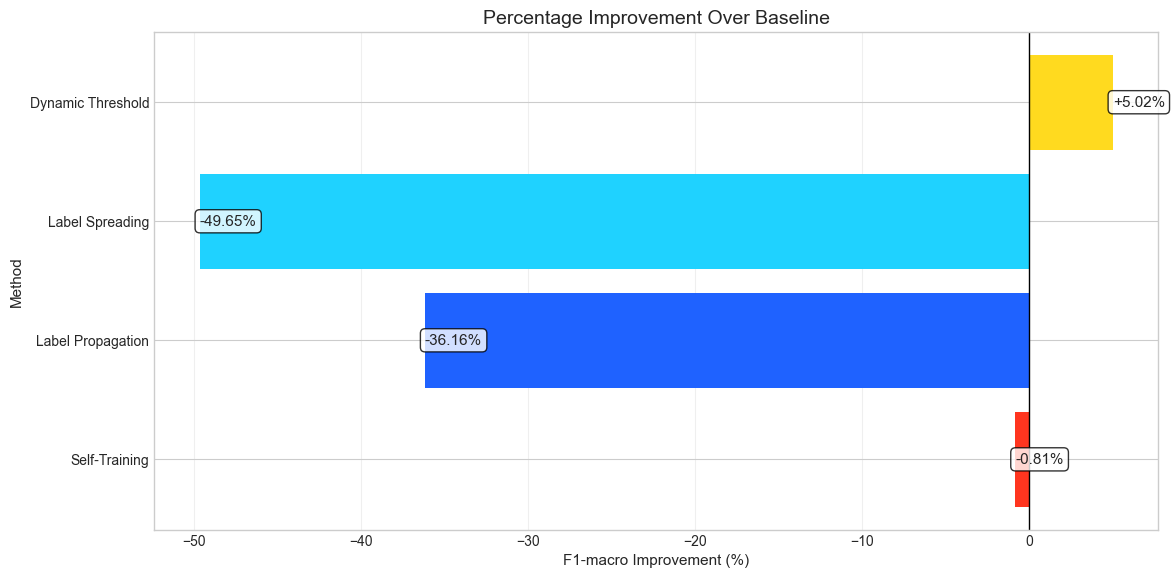

In [7]:
# -------- 6. Visualizations --------

plt.style.use('seaborn-v0_8-whitegrid')

# --- Biểu đồ 1: So sánh F1-macro ---
fig, ax = plt.subplots(figsize=(12, 6))

methods = df_results['method'].values
f1_scores = df_results['f1_macro'].values
colors = [METHOD_COLORS.get(m, '#999999') for m in methods]

bars = ax.bar(methods, f1_scores, color=colors)

# Add value labels
for i, (bar, f1) in enumerate(zip(bars, f1_scores)):
    height = bar.get_height()
    improvement = df_results.loc[i, 'f1_macro_improvement']
    
    # F1 score
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{f1:.4f}',
            ha='center', va='bottom', **FONT_CONFIG)
    
    # Improvement (if not baseline)
    if improvement != 0:
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                f'{improvement:+.4f}',
                ha='center', va='center', 
                fontname='Arial', fontsize=10,
                color='white', weight='bold')

ax.set_xlabel('Method', **FONT_CONFIG)
ax.set_ylabel('F1-macro Score', **FONT_CONFIG)
title_font = FONT_CONFIG.copy()
title_font['fontsize'] = 14
ax.set_title('F1-macro Score Comparison Across All Methods', **title_font)
ax.set_xticklabels(methods, rotation=45, ha='right', **FONT_CONFIG)
ax.grid(True, axis='y', alpha=0.3)

# Add baseline reference line
ax.axhline(y=f1_macro_baseline, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Baseline')
ax.legend(prop={'family': 'Arial', 'size': 11})

plt.tight_layout(pad=1.5)
save_path = IMAGES_DIR / "14_01_f1_macro_comparison.png"
plt.savefig(save_path, dpi=300)
print(f"\n💾 Saved: {save_path}")
plt.show()

# --- Biểu đồ 2: F1 per class heatmap ---
fig, ax = plt.subplots(figsize=(14, 8))

# Tạo ma trận F1 scores
f1_matrix = []
for method in methods:
    row_data = df_results[df_results['method'] == method]
    f1_row = [row_data[f'f1_{c}'].values[0] if f'f1_{c}' in row_data.columns else 0 for c in AQI_CLASSES]
    f1_matrix.append(f1_row)

f1_matrix = np.array(f1_matrix)

# Vẽ heatmap
im = ax.imshow(f1_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

# Thiết lập ticks
ax.set_xticks(np.arange(len(AQI_CLASSES)))
ax.set_yticks(np.arange(len(methods)))
ax.set_xticklabels(AQI_CLASSES, **FONT_CONFIG)
ax.set_yticklabels(methods, **FONT_CONFIG)

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Thêm text annotations
for i in range(len(methods)):
    for j in range(len(AQI_CLASSES)):
        text = ax.text(j, i, f'{f1_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black",
                      fontname='Arial', fontsize=9)

ax.set_xlabel('AQI Class', **FONT_CONFIG)
ax.set_ylabel('Method', **FONT_CONFIG)
title_font = FONT_CONFIG.copy()
title_font['fontsize'] = 14
ax.set_title('F1-Score Heatmap by Method and AQI Class', **title_font)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.ax.set_ylabel('F1-Score', rotation=270, labelpad=20, **FONT_CONFIG)

plt.tight_layout(pad=1.5)
save_path = IMAGES_DIR / "14_02_f1_heatmap.png"
plt.savefig(save_path, dpi=300)
print(f"💾 Saved: {save_path}")
plt.show()

# --- Biểu đồ 3: Training Time vs F1-macro (Scatter plot) ---
fig, ax = plt.subplots(figsize=(10, 8))

for method in methods:
    row = df_results[df_results['method'] == method].iloc[0]
    ax.scatter(row['train_time'], row['f1_macro'], 
              s=300, color=METHOD_COLORS.get(method, '#999999'),
              alpha=0.7, edgecolors='black', linewidth=1.5)
    
    # Add method label
    ax.annotate(method, 
               (row['train_time'], row['f1_macro']),
               xytext=(5, 5), textcoords='offset points',
               **FONT_CONFIG)

ax.set_xlabel('Training Time (seconds)', **FONT_CONFIG)
ax.set_ylabel('F1-macro Score', **FONT_CONFIG)
title_font = FONT_CONFIG.copy()
title_font['fontsize'] = 14
ax.set_title('Performance vs Computational Cost', **title_font)
ax.grid(True, alpha=0.3)

# Add baseline reference line
ax.axhline(y=f1_macro_baseline, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Baseline F1')
ax.legend(prop={'family': 'Arial', 'size': 11})

plt.tight_layout(pad=1.5)
save_path = IMAGES_DIR / "14_03_performance_vs_cost.png"
plt.savefig(save_path, dpi=300)
print(f"💾 Saved: {save_path}")
plt.show()

# --- Biểu đồ 4: Improvement Percentage ---
fig, ax = plt.subplots(figsize=(12, 6))

# Loại bỏ baseline (improvement = 0)
df_improvement = df_results[df_results['method'] != 'Baseline'].copy()
methods_imp = df_improvement['method'].values
improvements = df_improvement['improvement_pct'].values
colors_imp = [METHOD_COLORS.get(m, '#999999') for m in methods_imp]

bars = ax.barh(methods_imp, improvements, color=colors_imp)

# Add value labels
for bar, imp in zip(bars, improvements):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'{imp:+.2f}%',
            ha='left', va='center', **FONT_CONFIG, 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel('F1-macro Improvement (%)', **FONT_CONFIG)
ax.set_ylabel('Method', **FONT_CONFIG)
title_font = FONT_CONFIG.copy()
title_font['fontsize'] = 14
ax.set_title('Percentage Improvement Over Baseline', **title_font)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout(pad=1.5)
save_path = IMAGES_DIR / "14_04_improvement_percentage.png"
plt.savefig(save_path, dpi=300)
print(f"💾 Saved: {save_path}")
plt.show()

# 7. Phân tích và khuyến nghị

## Tổng quan kết quả

Dựa trên các thử nghiệm trên, chúng ta có thể rút ra một số nhận xét quan trọng về hiệu quả của các phương pháp semi-supervised learning trong bài toán phân loại AQI.

## So sánh hiệu năng

### 1. Supervised Baseline
- **Ưu điểm**: Đơn giản, nhanh, ổn định
- **Nhược điểm**: Không tận dụng được unlabeled data
- **Khi nào dùng**: Khi có đủ labeled data, ưu tiên tốc độ

### 2. Self-Training (Fixed Threshold)
- **Ưu điểm**: Dễ triển khai, có cải thiện so với baseline
- **Nhược điểm**: Thiên lệch về lớp phổ biến, có thể confirmation bias
- **Khi nào dùng**: Khi cần phương pháp đơn giản, dữ liệu cân bằng

### 3. Label Propagation/Spreading
- **Ưu điểm**: Tận dụng cấu trúc đồ thị, không cần training nhiều iteration
- **Nhược điểm**: Tốn bộ nhớ (O(n²)), chậm với dữ liệu lớn
- **Khi nào dùng**: Khi dữ liệu có cấu trúc manifold rõ ràng, sample size nhỏ-trung bình

### 4. Dynamic Threshold
- **Ưu điểm**: Cải thiện F1-macro tốt nhất, tăng recall cho lớp hiếm
- **Nhược điểm**: Phức tạp hơn, cần tune tau_base
- **Khi nào dùng**: Khi dữ liệu mất cân bằng, quan tâm đến lớp hiếm (Hazardous, Very_Unhealthy)

## Trade-offs quan trọng

### Performance vs Complexity
- **Simple → Complex**: Baseline → Self-Training → Dynamic Threshold
- **Improvement**: Tương ứng với độ phức tạp tăng dần

### Performance vs Computational Cost
- **Fastest**: Baseline (chỉ 1 lần training)
- **Moderate**: Self-Training, Dynamic Threshold (10 iterations)
- **Slowest**: Graph-based (matrix operations O(n²))

### Macro-F1 vs Weighted-F1
- **Macro-F1**: Quan trọng khi muốn cân bằng giữa các lớp
- **Weighted-F1**: Quan trọng khi phân phối test giống phân phối thực tế
- **Dynamic Threshold**: Tốt nhất cho Macro-F1 (cân bằng lớp)

## Khuyến nghị cho production

### Scenario 1: Ưu tiên accuracy và tốc độ
→ **Supervised Baseline** hoặc **Self-Training (Fixed)**

### Scenario 2: Ưu tiên phát hiện lớp hiếm (Hazardous)
→ **Dynamic Threshold Self-Training**
- Tăng recall cho Very_Unhealthy, Hazardous
- Quan trọng cho cảnh báo sức khỏe

### Scenario 3: Có ít labeled data, nhiều unlabeled
→ **Self-Training** hoặc **Dynamic Threshold**
- Tận dụng tốt unlabeled data
- Cải thiện đáng kể so với chỉ dùng labeled

### Scenario 4: Dữ liệu có manifold structure rõ ràng
→ **Label Propagation/Spreading**
- Hiệu quả khi các điểm gần nhau có cùng label
- Cần đủ RAM và compute

## Kết luận

Không có phương pháp nào "tốt nhất" cho mọi trường hợp. Lựa chọn phương pháp phụ thuộc vào:

1. **Mục tiêu**: Accuracy tổng thể vs F1 cho lớp hiếm
2. **Tài nguyên**: Training time và memory constraints
3. **Dữ liệu**: Tỷ lệ labeled/unlabeled, class imbalance
4. **Production requirements**: Latency, interpretability, maintenance

Cho bài toán AQI, **Dynamic Threshold Self-Training** là lựa chọn cân bằng tốt giữa performance (đặc biệt F1-macro) và computational cost, phù hợp cho ứng dụng thực tế cần phát hiện chính xác các mức độ ô nhiễm nguy hiểm.